# Discrete-Time Hazards and Survival Models with Bambi


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyArrowPatch
from scipy.special import expit, erf
import bambi as bmb
import arviz as az
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## The Regression Perspective on Survival

We take the view that **survival modeling is just regression with a clever data structure**.

The traditional machinery of survival analysis—Kaplan-Meier curves, log-rank tests, Cox proportional hazards—can feel like a separate statistical universe with its own notation, software, and rituals. But underneath, we're doing something quite simple: modeling the probability of an event occurring at time $t$, given that it hasn't occurred yet.

This perspective has several advantages:

- **Flexibility**: Use any regression framework (Bayesian, frequentist, ML)
- **Interpretability**: Coefficients have familiar interpretations
- **Extensions**: Easy to add random effects, non-linear terms, interactions
- **Software**: Use general-purpose tools rather than specialized survival packages

This notebook is part of a series where we will cover: (1) discrete time implementations of survival models and (2) continuous time implementations of survival models. Here we're focused on (1) and wish to set up the broad ideas of how survival models are well phrased as regression problems. 

## Accumulating Risk: First a trickle, then a Flood

Before diving into the math, let’s build intuition with a thought experiment. When does a collection of sand grains become a heap? When is a downpour a flood? How do different processes of accumulation yield categorical distinctions or presage state-transitions? These are the questions at the heart of survival modelling. 

::: {.callout-note}
## The Sorites Paradox and Survival

The ancient Sorites paradox asks: if you start with no heap of sand and add one grain at a time, when does it become a heap? One grain does not make a heap; neither do two or three, but eventually, accumulation produces a qualitative change. A state-transition has occured and we've moved into a new categorical outcome.

Survival analysis adopts this *accumulation* perspective. A patient or system starts in a functioning state. Each day, a small amount of latent risk accumulates. No single day is decisive, but over time these increments build toward a transition. While accumulated risk always increases, the rate of accumulation may rise or fall over time. An event occurs when accumulated risk crosses a latent threshold.

The **hazard rate** governs how quickly risk accumulates at each moment, conditional on having not yet experienced the event. The **survival function** records the probability that accumulated risk has not yet crossed the threshold.
:::

This metaphor captures several core features of survival processes:

- **Risk accumulates over time**, either continuously or in discrete increments
- **Conditional probability is central**: today’s hazard is defined only among those who have not yet crossed the threshold
- **Survival is multiplicative**: each period adds incremental risk, so survival is the product of surviving each interval

Survival analysis models events as the outcome of an underlying (latent) "risk" accumulation process evolving over time. The baseline hazard determines the typical rate at which risk accumulates, while covariates shift that rate upward or downward. In discrete-time survival models, we approximate this process by modeling conditional transition probabilities over observed time intervals. Accumulated risk reflects both (a) the baseline hazard and (b) individual-specific risk factors that alter the pace of accumulation.

In a sense we're being too specific when we call the accumulation "risk", it suggests that we're headed only to negative events. The generality of survival modelling is obscured by this focus. In survival modelling we're **mapping a developmental process** that culminates in change. Anywhere there is an evolving state that culminates in a categorical/qualitative change can profitably treated by survival analysis.

To visualize this idea, consider the figure below. The left panel shows accumulated risk building over time toward a transition, while the right panel displays the corresponding hazard and survival quantities at each step. Each time period contributes a small increment of risk; together, these increments produce a declining probability of remaining event-free.


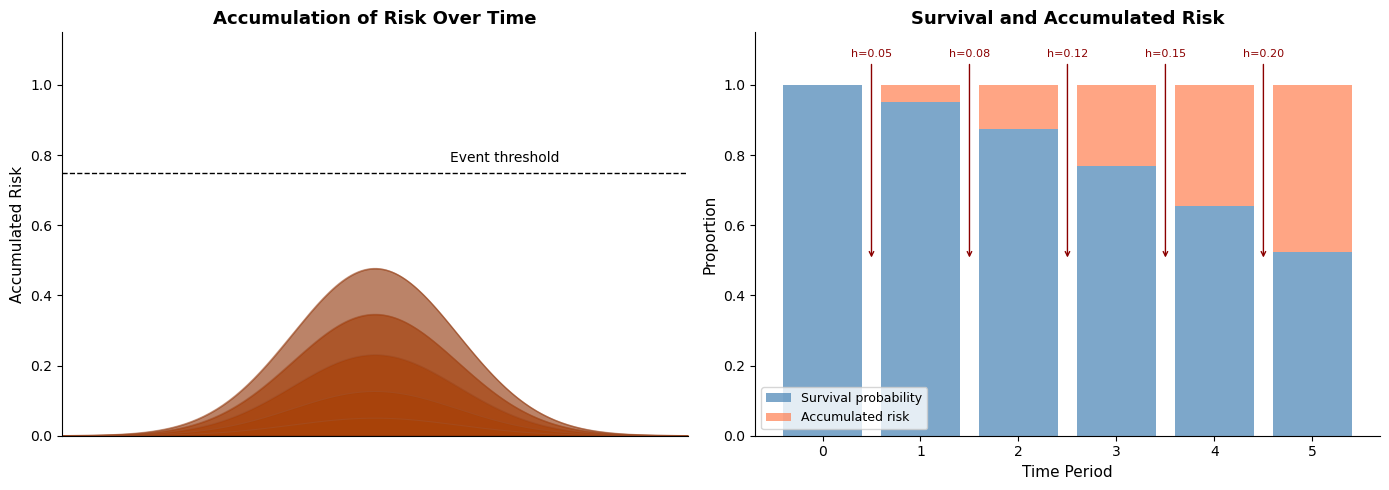

In [ ]:
#| code-fold: true

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Left panel: accumulated risk heap ---
ax = axes[0]
x = np.linspace(0, 10, 200)

hazards_demo = [0.05, 0.08, 0.12, 0.15, 0.20]
survival_demo = [1.0]
for h in hazards_demo:
    survival_demo.append(survival_demo[-1] * (1 - h))

# Accumulated risk = 1 - survival
risk_demo = [1 - s for s in survival_demo]

colors = plt.cm.YlOrBr(np.linspace(0.3, 0.9, len(risk_demo)))

for i, r in enumerate(risk_demo):
    y = r * np.exp(-(x - 5)**2 / 3.5)
    ax.fill_between(x, 0, y, alpha=0.6, color=colors[i])
    ax.plot(x, y, color='sienna', alpha=0.5, linewidth=0.8)

ax.axhline(0.75, linestyle='--', color='black', linewidth=1)
ax.text(6.2, 0.78, 'Event threshold', fontsize=10)

ax.set_xlim(0, 10)
ax.set_ylim(0, 1.15)
ax.set_xticks([])
ax.set_ylabel('Accumulated Risk', fontsize=11)
ax.set_title('Accumulation of Risk Over Time', fontsize=13, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# --- Right panel: survival vs accumulated risk ---
ax2 = axes[1]
periods = np.arange(0, len(hazards_demo) + 1)

survival_arr = np.array(survival_demo)
risk_arr = 1 - survival_arr

ax2.bar(periods, survival_arr, color='steelblue', alpha=0.7, label='Survival probability')
ax2.bar(periods, risk_arr, bottom=survival_arr, color='coral', alpha=0.7, label='Accumulated risk')

for i, h in enumerate(hazards_demo):
    ax2.annotate(f'h={h:.2f}', xy=(i + 0.5, 0.5), xytext=(i + 0.5, 1.08),
                 fontsize=8, ha='center', color='darkred',
                 arrowprops=dict(arrowstyle='->', color='darkred', lw=1))

ax2.set_xlabel('Time Period', fontsize=11)
ax2.set_ylabel('Proportion', fontsize=11)
ax2.set_title('Survival and Accumulated Risk', fontsize=13, fontweight='bold')
ax2.set_ylim(0, 1.15)
ax2.legend(loc='lower left', fontsize=9)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

The key idea is that no single increment of risk is decisive, but together they are. Each hazard contribution is small, yet accumulated risk steadily increases until a transition occurs. This is precisely the structure that discrete-time survival models are designed to capture.

Let’s now formalize this intuition.

### The Mathematical Framework

#### The Survival Trinity: $h(t)$, $H(t)$, $S(t)$

In survival analysis, we work with three interconnected functions. Understanding their relationships is crucial.

**Discrete Time Definitions:**

Let $T$ be the random variable representing time-to-event. This "event"  denotes the occurrence of some state-transition. The subject that experiences event has moved from one qualitative state to another: live-to-dead or employed-to-fired. We are interested in how long it takes for this type of state-transition to occur. In discrete time with periods $t = 1, 2, 3, \ldots$:

**Hazard Function** $h(t)$: The probability of the event occurring in period $t$, given survival to period $t$:

$$h(t) = P(T = t \mid T \geq t)$$

This is a **conditional probability**—the risk among those still at risk.

**Survival Function** $S(t)$: The probability of surviving past time $t$:

$$S(t) = P(T > t) = \prod_{j=1}^{t} (1 - h(j))$$

The survival function is the product of "not experiencing the event" across all prior periods.

**Cumulative Hazard** $H(t)$: The accumulated risk up to time $t$:

$$H(t) = \sum_{j=1}^{t} h(j)$$

In discrete time, this is simply the sum of period-specific hazards — a running total of the risk increments at each step. Returning to the Sorites metaphor: $H(t)$ counts up the grains of sand we've added so far.

Note, however, that the survival function uses a *product* of $(1-h(j))$ terms, not a sum. To connect cumulative hazard to survival more precisely, take the log of the survival function:

$$\log S(t) = \sum_{j=1}^{t} \log(1 - h(j))$$

This means the natural "per-period contribution to log-survival" is $\log(1 - h(j))$, which is always negative. Define the **log-survival contribution** as $-\log(1 - h(j))$: the amount each period chips away at log-survival. Then:

$$-\log S(t) = \sum_{j=1}^{t} [-\log(1 - h(j))]$$

When hazards are small, $-\log(1 - h) \approx h$ (first-order Taylor expansion), so the simple sum $H(t) = \sum h(j)$ is a good approximation. But the exact relationship runs through $-\log(1-h)$, not $h$ itself. This distinction will matter when we choose a link function for regression — we want one that respects this log-survival structure. We'll return to this in @sec-continuous-to-discrete.

We can visualise these relationships below. 


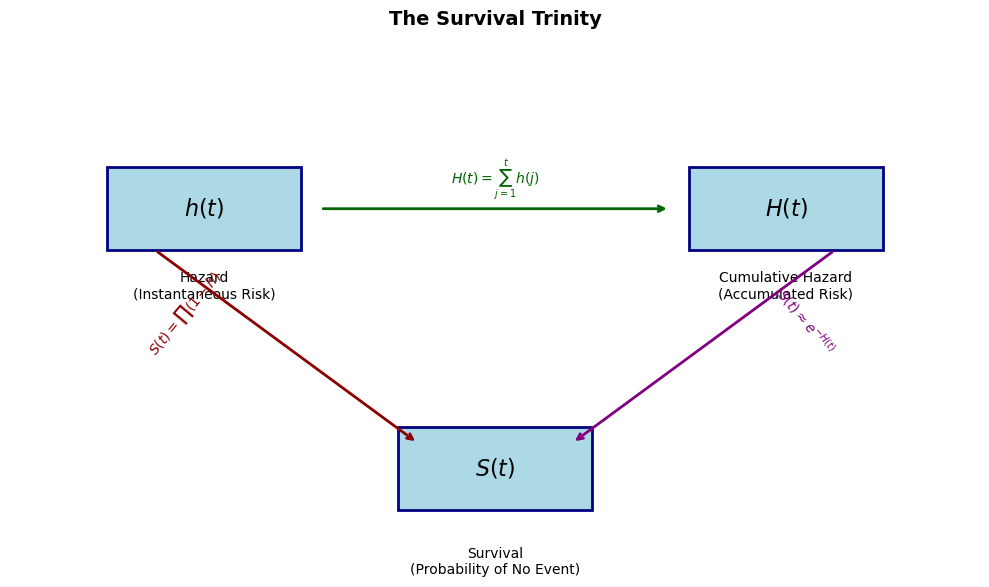

In [ ]:
#| code-fold: true

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')

# Draw boxes
boxes = {
    'h(t)': (2, 7),
    'H(t)': (8, 7),
    'S(t)': (5, 2)
}

for label, (x, y) in boxes.items():
    ax.add_patch(plt.Rectangle((x-1, y-0.8), 2, 1.6,
                                fill=True, facecolor='lightblue',
                                edgecolor='navy', linewidth=2))
    ax.text(x, y, f'${label}$', ha='center', va='center', fontsize=16, fontweight='bold')

# Add descriptions
ax.text(2, 5.8, 'Hazard\n(Instantaneous Risk)', ha='center', va='top', fontsize=10)
ax.text(8, 5.8, 'Cumulative Hazard\n(Accumulated Risk)', ha='center', va='top', fontsize=10)
ax.text(5, 0.5, 'Survival\n(Probability of No Event)', ha='center', va='top', fontsize=10)

# Draw arrows with labels
ax.annotate('', xy=(6.8, 7), xytext=(3.2, 7),
            arrowprops=dict(arrowstyle='->', color='darkgreen', lw=2))
ax.text(5, 7.5, r'$H(t) = \sum_{j=1}^{t} h(j)$', ha='center', fontsize=10, color='darkgreen')

ax.annotate('', xy=(4.2, 2.5), xytext=(1.5, 6.2),
            arrowprops=dict(arrowstyle='->', color='darkred', lw=2))
ax.text(1.8, 4.2, r'$S(t) = \prod(1-h)$', ha='center', fontsize=10, color='darkred', rotation=50)

ax.annotate('', xy=(5.8, 2.5), xytext=(8.5, 6.2),
            arrowprops=dict(arrowstyle='->', color='purple', lw=2))
ax.text(8.2, 4.2, r'$S(t) \approx e^{-H(t)}$', ha='center', fontsize=10, color='purple', rotation=-50)

plt.title('The Survival Trinity', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

As we step through time the latent hazard evolves and this translates into changes in the probability of state-change. 

::: {.callout-important}
## Why Focus on the Hazard?

In survival regression, we model the **hazard** $h(t)$, not the survival function directly. Why?

1. **Covariates act on hazard**: Most scientific questions are about what affects risk *at each moment*
2. **Multiplicative interpretation**: Hazard ratios are intuitive (2x the risk per period)
3. **Censoring is natural**: We model "did event happen in this period, among those at risk?" This respects the idea that not all subjects observe an event of state-transition. 
4. **Additivity on log scale**: Log-hazards combine additively, like linear regression
:::

### From Continuous to Discrete Time {#sec-continuous-to-discrete}

In continuous time, the hazard is an **instantaneous rate**, not a probability:

$$\lambda(t) = \lim_{\Delta t \to 0} \frac{P(t \leq T < t + \Delta t \mid T \geq t)}{\Delta t}$$

The continuous-time relationships are:
$$S(t) = \exp\left(-\int_0^t \lambda(u) du\right) = \exp(-\Lambda(t))$$

When we discretize time into intervals, each interval hazard is:
$$h_t \approx 1 - \exp(-\lambda_t \cdot \Delta t)$$

This approximation becomes exact with the **complementary log-log** link, which we'll explore soon.

## The Person-Period Data Structure

We've outlined a picture of survival analysis as a study of evolving hazard. This focus mandates a targeted view of the risk that appropriately maps to the individual. As a patient you want the assessment of your chances for survival to be maximally relevant. One way to ensure the feasibility is to use a person-period data structure, encoding a discrete view of time in which we allow for evolving hazards. 

### Why Restructure the Data?

To use regression, we need a structure in which to represent baseline hazards. **The key transformation** creates one row for each time period that each subject was "at risk." This data expansion makes __the accumulation of risk__ explicit by representing each unit of time during which the subject remains at risk. We'll see how this enables regression modelling with flexible baseline hazards below. But first it should be noted that this expansion can prove computationally expensive.



In [5]:
#| echo: false


# Show the transformation visually
original = pd.DataFrame({
    'Subject': ['A', 'B', 'C'],
    'Time': [3, 5, 4],
    'Event': [1, 0, 1],
    'Treatment': [1, 0, 1]
})

expanded = pd.DataFrame({
    'Subject': ['A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'C', 'C', 'C', 'C'],
    'Period': [1, 2, 3, 1, 2, 3, 4, 5, 1, 2, 3, 4],
    'Event': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    'Treatment': [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1]
})

print("ORIGINAL DATA (one row per subject):")
print(original.to_string(index=False))
print("\n" + "="*50)
print("\nPERSON-PERIOD DATA (one row per period at risk):")
print(expanded.to_string(index=False))

ORIGINAL DATA (one row per subject):
Subject  Time  Event  Treatment
      A     3      1          1
      B     5      0          0
      C     4      1          1


PERSON-PERIOD DATA (one row per period at risk):
Subject  Period  Event  Treatment
      A       1      0          1
      A       2      0          1
      A       3      1          1
      B       1      0          0
      B       2      0          0
      B       3      0          0
      B       4      0          0
      B       5      0          0
      C       1      0          1
      C       2      0          1
      C       3      0          1
      C       4      1          1


Notice several important features:

- **Subject A** has event=1 only in their final period (period 3)
- **Subject B** is **censored** at time 5 — meaning we observed them for 5 periods without seeing the event, but we don't know whether they would have experienced it later — so all their event indicators are 0
- **Subject C** has event=1 in period 4 when they experienced the event
- Each subject contributes rows **only for periods they were at risk**

#### Implementing the Transformation

Let's write a general function to create person-period data:


In [6]:
def create_person_period_data(df, id_col, time_col, event_col, covariates):
    """
    Transform survival data to person-period format.

    Parameters
    ----------
    df : DataFrame
        Original survival data (one row per subject)
    id_col : str
        Column name for subject identifier
    time_col : str
        Column name for observed time (event or censoring)
    event_col : str
        Column name for event indicator (1=event, 0=censored)
    covariates : list
        Column names for covariates to carry forward

    Returns
    -------
    DataFrame in person-period format
    """
    records = []

    for _, row in df.iterrows():
        duration = int(np.ceil(row[time_col]))

        for t in range(1, duration + 1):
            # Event only in final period if event occurred
            is_final = (t == duration)
            event_in_period = 1 if (is_final and row[event_col] == 1) else 0

            record = {
                id_col: row[id_col],
                'period': t,
                'event': event_in_period
            }

            # Carry forward covariates
            for cov in covariates:
                record[cov] = row[cov]

            records.append(record)

    return pd.DataFrame(records)

::: {.callout-tip}
## Computational Efficiency

For large datasets, person-period format can become unwieldy. Instead of creating individual rows, we can **aggregate** counts of events and subjects at risk within covariate strata. This is especially powerful with categorical covariates and leads to binomial rather than Bernoulli likelihoods. We will show this efficiency step below. 
:::

## Simulation Study: Validating the Approach

Before applying our methods to real data, let's verify they work on data where we know the true parameters.

#### Generating Discrete-Time Survival Data

We'll simulate data from a discrete-time proportional hazards model:

$$h(t | X) = 1 - \exp(-\exp(\alpha_t + X\beta))$$

where:
- $\alpha_t$ is the log baseline hazard at time $t$
- $X\beta$ is the linear predictor from covariates
- The cloglog link ensures the proportional hazards interpretation


In [7]:
np.random.seed(98)

# Simulation parameters
n = 2000  # Number of subjects
max_time = 8  # Maximum follow-up periods

# Generate covariates
treatment = np.random.binomial(1, 0.5, n)
age_raw = np.random.normal(50, 10, n)
age = (age_raw - age_raw.mean()) / age_raw.std()  # Standardize

# TRUE PARAMETERS (what we want to recover)
beta_treatment = 0.5  # Treatment increases hazard
beta_age = 0.3        # Older age increases hazard

# Baseline hazard increases over time (like aging or disease progression)
baseline_hazard = np.array([0.05, 0.06, 0.08, 0.10, 0.12, 0.15, 0.18, 0.20])

print("SIMULATION PARAMETERS")
print("=" * 50)
print(f"Sample size: {n}")
print(f"Max follow-up: {max_time} periods")
print(f"\nTrue coefficients:")
print(f"  β_treatment = {beta_treatment}")
print(f"  β_age = {beta_age}")
print(f"\nBaseline hazards by period:")
for t, h in enumerate(baseline_hazard, 1):
    print(f"  Period {t}: h₀ = {h:.2f}")

SIMULATION PARAMETERS
Sample size: 2000
Max follow-up: 8 periods

True coefficients:
  β_treatment = 0.5
  β_age = 0.3

Baseline hazards by period:
  Period 1: h₀ = 0.05
  Period 2: h₀ = 0.06
  Period 3: h₀ = 0.08
  Period 4: h₀ = 0.10
  Period 5: h₀ = 0.12
  Period 6: h₀ = 0.15
  Period 7: h₀ = 0.18
  Period 8: h₀ = 0.20


In [8]:
# Simulate failure times
failure_times = []
event_indicators = []

for i in range(n):
    # Linear predictor (covariate contribution)
    linear_pred = beta_treatment * treatment[i] + beta_age * age[i]

    # Walk through time periods
    survived = True
    failure_time = max_time + 1  # Default: censored at end

    for t in range(max_time):
        # Hazard at this time point (cloglog parameterization)
        eta = np.log(baseline_hazard[t]) + linear_pred
        prob_event = 1 - np.exp(-np.exp(eta))  # cloglog inverse link

        # Does event occur?
        if np.random.random() < prob_event:
            failure_time = t + 1
            survived = False
            break

    failure_times.append(failure_time)
    event_indicators.append(0 if survived else 1)

print(f"\nSIMULATION RESULTS")
print("=" * 50)
print(f"Events: {sum(event_indicators)} ({100*np.mean(event_indicators):.1f}%)")
print(f"Censored: {n - sum(event_indicators)} ({100*(1-np.mean(event_indicators)):.1f}%)")


SIMULATION RESULTS
Events: 1418 (70.9%)
Censored: 582 (29.1%)


### Creating Person-Period Format

Now we reuse the `create_person_period_data` function defined earlier — this is exactly the transformation it was designed for:


In [9]:
# Package simulation results into a subject-level DataFrame
df_subjects = pd.DataFrame({
    'id': np.arange(n),
    'time': np.minimum(failure_times, max_time),
    'event': event_indicators,
    'treatment': treatment,
    'age': age
})

# Reuse our general-purpose function
df_sim = create_person_period_data(
    df_subjects,
    id_col='id',
    time_col='time',
    event_col='event',
    covariates=['treatment', 'age']
)
df_sim['time_cat'] = df_sim['period'].astype(str)

print(f"Person-period dataset: {len(df_sim):,} rows")
print(f"Total events: {df_sim['event'].sum():,}")
print(f"\nEvent rate by time period:")
print(df_sim.groupby('period')['event'].agg(['sum', 'count', 'mean']).round(3))

Person-period dataset: 11,328 rows
Total events: 1,418

Event rate by time period:
        sum  count   mean
period                   
1       129   2000  0.064
2       132   1871  0.071
3       197   1739  0.113
4       204   1542  0.132
5       193   1338  0.144
6       201   1145  0.176
7       195    944  0.207
8       167    749  0.223


In this person-period summary, each row is one time period. **sum** is the number of events (deaths, failures) observed in that period, **count** is the number of subjects still at risk (i.e. who have a row for that period in the expanded data), and **mean** is the ratio of the two — the observed hazard rate for that period. Notice that the count decreases over time as subjects either experience the event or are censored.

### Fitting the Discrete-Time Hazard Model

Now for the key insight: we fit a **binary regression model** (event yes/no) with the **complementary log-log link**.

#### Why Cloglog?

In a binary regression for "did the event happen this period?", we need a **link function** mapping the linear predictor $\eta$ to a probability. The usual choice for binary outcomes is the logit link, but the accumulation structure of survival gives us a reason to prefer something else.

Recall from the mathematical framework that survival is the product of not-yet-transitioning at each step, and that the per-period contribution to log-survival is $-\log(1 - h(t))$. This quantity — not the hazard itself — is what accumulates additively on the log-survival scale. If we want our linear predictor $\eta$ to model this additive contribution directly, we need:

$$-\log(1 - h(t)) = \exp(\eta)$$

Why $\exp(\eta)$? Because the contribution to log-survival must be non-negative (each period can only reduce survival, never increase it), and the exponential ensures this regardless of the sign of $\eta$. Solving for $h(t)$:

$$h(t) = 1 - \exp(-\exp(\eta))$$

This is the **complementary log-log (cloglog)** link function. It isn't an arbitrary choice — it's the link that makes the linear predictor additive on the log-survival scale. Each covariate shifts $\eta$, which multiplicatively scales the per-period log-survival contribution, which means **coefficients are interpretable as log hazard ratios**: a coefficient of $\beta$ means the per-period contribution to log-survival is multiplied by $\exp(\beta)$. This is the proportional hazards property.

The logit link doesn't have this structure — its coefficients are log *odds* ratios, which only approximate hazard ratios when event probabilities are small. In practice, hazards are often easier to reason about than odds of failure, because they correspond directly to a conditional risk of transitioning at each step in the accumulation process.

The plot below compares the three common link functions. Notice that cloglog is **asymmetric**: it approaches 0 slowly from below but rises sharply toward 1. This asymmetry reflects the accumulation logic — once per-period risk contributions start building up, the probability of the event accelerates.


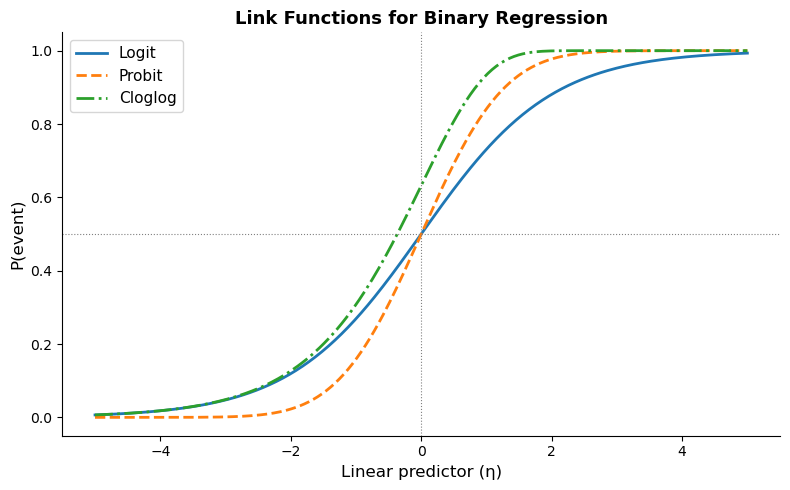

In [ ]:
#| code-fold: true

eta = np.linspace(-5, 5, 300)

p_logit = expit(eta)
p_probit = 0.5 * (1 + erf(eta / np.sqrt(2)))
p_cloglog = 1 - np.exp(-np.exp(eta))

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(eta, p_logit, label='Logit', linewidth=2)
ax.plot(eta, p_probit, label='Probit', linewidth=2, linestyle='--')
ax.plot(eta, p_cloglog, label='Cloglog', linewidth=2, linestyle='-.')
ax.axhline(0.5, color='gray', linewidth=0.8, linestyle=':')
ax.axvline(0, color='gray', linewidth=0.8, linestyle=':')
ax.set_xlabel('Linear predictor (η)', fontsize=12)
ax.set_ylabel('P(event)', fontsize=12)
ax.set_title('Link Functions for Binary Regression', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

Let's now put the pieces together. Our model formula is:

$$\text{cloglog}(h_t) = \log(-\log(1 - h_t)) = \alpha_t + \beta_1 \cdot \text{treatment} + \beta_2 \cdot \text{age}$$

In Bambi's formula syntax, `event ~ treatment + age + C(time_cat)`, each component plays a specific role:

- **`event`** (left-hand side): the binary outcome — did the event occur in this person-period row? This is what we're modeling the probability of.
- **`treatment` and `age`** (covariates): shift the hazard up or down. Their coefficients $\beta_1, \beta_2$ are log hazard ratios.
- **`C(time_cat)`** (categorical time dummies): these are the $\alpha_t$ terms — a separate intercept for each time period. Together they form the **baseline hazard**, the pattern of risk over time when covariates are at their reference values. Using categorical dummies is fully flexible: we make no assumption about the shape of the baseline hazard.
- **`family='bernoulli', link='cloglog'`**: each person-period row is a Bernoulli trial (event or no event), and we use the cloglog link so that coefficients have the proportional hazards interpretation derived above.


In [11]:
#| output: false
model_cloglog = bmb.Model(
    'event ~ treatment + age + C(time_cat)',
    data=df_sim,
    family='bernoulli',
    link='cloglog',
    priors={
        'treatment': bmb.Prior('Normal', mu=0, sigma=1),
        'age': bmb.Prior('Normal', mu=0, sigma=1),
    }
)

We can spell out the structure a bit more by printing the model structure and plotting the data generating process. 

In [12]:
print("Model specification:")
print(model_cloglog)

Model specification:
       Formula: event ~ treatment + age + C(time_cat)
        Family: bernoulli
          Link: p = cloglog
  Observations: 11328
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 3.4865)
            treatment ~ Normal(mu: 0.0, sigma: 1.0)
            age ~ Normal(mu: 0.0, sigma: 1.0)
            C(time_cat) ~ Normal(mu: [0. 0. 0. 0. 0. 0. 0.], sigma: [ 6.7326  6.9352  7.2904  7.7461  8.2938
                9.0453 10.0607])



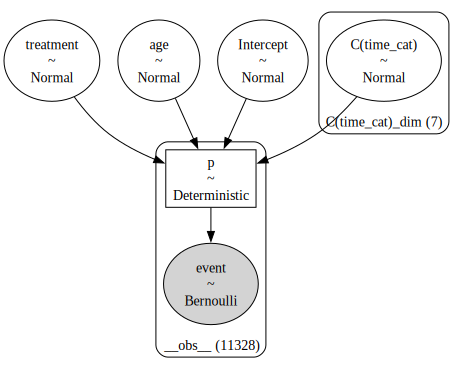

In [15]:
model_cloglog.build()
model_cloglog.graph()

We then fit the model just like any bambi model. 

In [16]:
# Fit the model (this may take a minute)
results_cloglog = model_cloglog.fit(
    draws=1000,
    tune=2000,
    chains=4,
    target_accept=0.95,
    random_seed=42,
    inference_method='numpyro',  # Use NUTS sampler
    idata_kwargs={"log_likelihood": True}
)

Modeling the probability that event==1


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [17]:
# Display results
print("POSTERIOR SUMMARY")
print("=" * 60)
summary = az.summary(results_cloglog, hdi_prob=0.95,
                      var_names=['treatment', 'age'])
print(summary)

print(f"\nTRUE VALUES:")
print(f"  β_treatment = {beta_treatment}")
print(f"  β_age = {beta_age}")

POSTERIOR SUMMARY
            mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
treatment  0.499  0.052     0.397      0.599      0.001    0.001    2800.0   
age        0.280  0.028     0.229      0.336      0.001    0.000    2989.0   

           ess_tail  r_hat  
treatment    2810.0    1.0  
age          2638.0    1.0  

TRUE VALUES:
  β_treatment = 0.5
  β_age = 0.3


Here we see how the posterior parameter estimates accurately capture the true data generating parameters. We should state now how to interpret these parameters. 

::: {.callout-note}
## Interpreting the Coefficients

The coefficients from a cloglog model are **log hazard ratios**:

- `treatment = 0.5` means treated subjects have $\exp(0.5) \approx 1.65$ times the hazard of untreated subjects
- `age = 0.3` means a one-standard-deviation increase in age multiplies the hazard by $\exp(0.3) \approx 1.35$

These are **proportional effects**: they multiply the baseline hazard by the same factor at every time point. Coefficients describe how covariates alter the rate at which risk accumulates across intervals, rather than the probability of the event in isolation.
:::

#### Visualizing Parameter Recovery


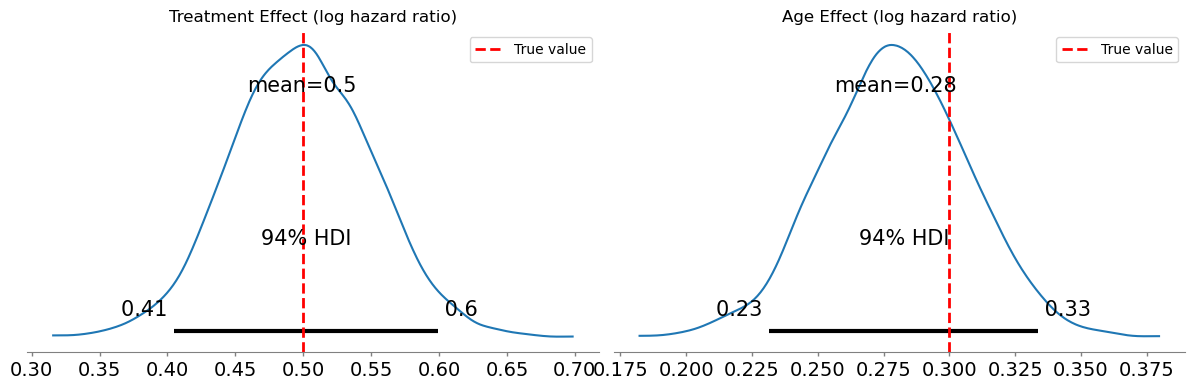

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Treatment effect
az.plot_posterior(results_cloglog.posterior['treatment'], ax=axes[0])
axes[0].axvline(beta_treatment, color='red', linestyle='--', linewidth=2, label='True value')
axes[0].set_title('Treatment Effect (log hazard ratio)')
axes[0].legend()

# Age effect
az.plot_posterior(results_cloglog.posterior['age'], ax=axes[1])
axes[1].axvline(beta_age, color='red', linestyle='--', linewidth=2, label='True value')
axes[1].set_title('Age Effect (log hazard ratio)')
axes[1].legend()

plt.tight_layout()
plt.show()

### Recovering the Baseline Hazard

The time-period indicators estimate the **log baseline hazard** (plus the intercept).


In [19]:
# Extract full posterior samples for intercept and time effects
# Intercept: shape (chains, draws) -> flatten to (n_samples,)
intercept_post = results_cloglog.posterior['Intercept'].values.flatten()
n_samples = len(intercept_post)

# Time effects: Bambi stores C(time_cat) as a single variable with shape
# (chains, draws, n_levels). Reshape to (n_samples, n_levels).
time_effects_post = results_cloglog.posterior['C(time_cat)'].values.reshape(n_samples, -1)

# Build posterior samples of log baseline hazard for each period
# Period 1 is the reference category (intercept only), remaining periods add their effect
log_baseline_post = np.column_stack([
    intercept_post[:, None],
    intercept_post[:, None] + time_effects_post
])

# True log baseline hazard
true_log_baseline = np.log(baseline_hazard)

# Convert to hazard probability scale via inverse cloglog: h = 1 - exp(-exp(eta))
baseline_hazard_post = 1 - np.exp(-np.exp(log_baseline_post))

# Compute summaries
log_baseline_median = np.median(log_baseline_post, axis=0)
log_baseline_hdi = np.quantile(log_baseline_post, [0.03, 0.97], axis=0)

hazard_median = np.median(baseline_hazard_post, axis=0)
hazard_hdi = np.quantile(baseline_hazard_post, [0.03, 0.97], axis=0)

periods = np.arange(1, max_time + 1)

To recover the baseline hazard from our fitted model, we have:

1. **Extracted posterior samples** of the intercept and the categorical time effects from the fitted model. The intercept alone gives us the log baseline hazard for the reference period (period 1). For every other period, its log baseline hazard is the intercept plus that period's estimated offset.
2. **Transformed to the probability scale** using the inverse cloglog: $h = 1 - \exp(-\exp(\eta))$. This converts the linear predictor back into the per-period event probability — the quantity we originally simulated as `baseline_hazard`.
3. **Summarized** with medians and HDI bands, giving us not just a point estimate but a sense of how precisely the model has recovered each period's hazard.


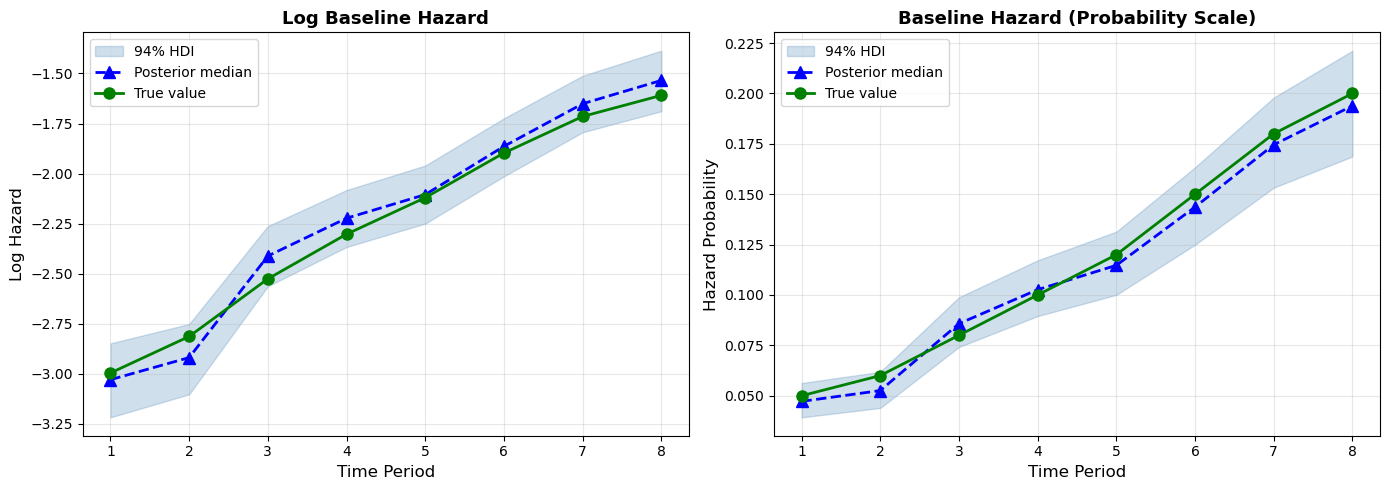

In [20]:
#| fig-cap: "Baseline hazard recovery on log and probability scales. Shaded bands show 94% HDI from the posterior."
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Left panel: log baseline hazard ---
ax = axes[0]
ax.fill_between(periods, log_baseline_hdi[0], log_baseline_hdi[1],
                color='steelblue', alpha=0.25, label='94% HDI')
ax.plot(periods, log_baseline_median, 'b^--', markersize=8, linewidth=2,
        label='Posterior median')
ax.plot(periods, true_log_baseline, 'go-', markersize=8, linewidth=2,
        label='True value')
ax.set_xlabel('Time Period', fontsize=12)
ax.set_ylabel('Log Hazard', fontsize=12)
ax.set_title('Log Baseline Hazard', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# --- Right panel: hazard probability ---
ax2 = axes[1]
ax2.fill_between(periods, hazard_hdi[0], hazard_hdi[1],
                 color='steelblue', alpha=0.25, label='94% HDI')
ax2.plot(periods, hazard_median, 'b^--', markersize=8, linewidth=2,
         label='Posterior median')
ax2.plot(periods, baseline_hazard, 'go-', markersize=8, linewidth=2,
         label='True value')
ax2.set_xlabel('Time Period', fontsize=12)
ax2.set_ylabel('Hazard Probability', fontsize=12)
ax2.set_title('Baseline Hazard (Probability Scale)', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The model successfully recovers both the covariate effects and the shape of the baseline hazard. The right panel shows the recovered hazard probabilities — the original `baseline_hazard` values used in the simulation — with posterior uncertainty. The true values fall comfortably within the 94% HDI bands at every time period.

## Case Study: Historical Child Mortality

Now let's apply these methods to real data. We'll analyze historical child mortality data, examining how survival varied by social class, sex, and birth year. We draw this example and inspiration from Goran Brostrom's _Event History Analysis with R_. 

::: {.callout-note}
## About the Data

This dataset comes from historical parish records in 19th-century Sweden (roughly 1850–1890), where churches maintained detailed registers of births, deaths, and family circumstances. Child mortality was common during this period — infectious disease, malnutrition, and limited medical care meant that a substantial fraction of children did not survive to age 15. The data lets us examine how survival varied across social strata at a time when class differences in living conditions were stark.

Key variables:

- **id**: Child identifier
- **exit**: Age at death or censoring (in years, max 15)
- **event**: Whether death occurred (1) or child was censored/survived to 15 (0)
- **sex**: male/female
- **socBranch**: Father's social class (official, business, farming, worker, etc.)
- **birthdate**: Date of birth
- **m.age**: Mother's age at birth
- **illeg**: Whether the birth was illegitimate (yes/no)

The censoring at age 15 means we are studying *childhood* mortality specifically — children who survived to 15 exit the study, and we do not observe whether they die later.
:::

### Data Preparation

We load the data first and print out some summary statistics. 


In [25]:
#| eval: true
# Load the child mortality data
child = pd.read_csv('data/child.csv')
child.head()
child['birth_year'] = pd.to_datetime(child['birthdate']).dt.year

print(f"Dataset: {len(child)} children")
print(f"\nSummary statistics:")
print(child[['exit', 'event']].describe())
print(f"\nEvent rate: {child['event'].mean():.1%}")
print(f"\nSex distribution:\n{child['sex'].value_counts()}")
print(f"\nSocial class distribution:\n{child['socBranch'].value_counts()}")

Dataset: 26574 children

Summary statistics:
               exit         event
count  26574.000000  26574.000000
mean      12.231114      0.211334
std        5.258355      0.408263
min        0.003000      0.000000
25%       15.000000      0.000000
50%       15.000000      0.000000
75%       15.000000      0.000000
max       15.000000      1.000000

Event rate: 21.1%

Sex distribution:
sex
male      13676
female    12898
Name: count, dtype: int64

Social class distribution:
socBranch
farming     18641
worker       7005
official      610
business      318
Name: count, dtype: int64


#### Creating Person-Period Format

We reuse `create_person_period_data` again — the same function we used for the simulation data. We also bin birth year into decades, since individual years create too many strata for efficient aggregation later.


In [26]:
#| eval: true
# Bin birth year into decades for more meaningful aggregation
child['birth_decade'] = (child['birth_year'] // 10) * 10

# Reuse the general-purpose person-period transformation
df_long = create_person_period_data(
    child,
    id_col='id',
    time_col='exit',
    event_col='event',
    covariates=['sex', 'socBranch', 'm.age', 'illeg', 'birth_decade']
)

print(f"Person-period rows: {len(df_long):,}")
print(f"Total events: {df_long['event'].sum():,}")

Person-period rows: 328,671
Total events: 5,616


This is now a large data set but we can reduce the computational burden if we cleverly aggregate the cases. 

#### Aggregating for Efficiency

With categorical covariates, we can aggregate to count data. This collapses many individual Bernoulli observations into binomial counts per stratum, dramatically reducing dataset size.


In [27]:
def aggregate_person_period(df_long, group_cols, event_col='event'):
    """
    Aggregate person-period data into binomial counts per covariate stratum.

    Parameters
    ----------
    df_long : DataFrame
        Person-period data with one row per person-period
    group_cols : list
        Columns defining the strata to aggregate over
    event_col : str
        Name of the binary event column

    Returns
    -------
    DataFrame with 'events' (sum) and 'at_risk' (count) per stratum
    """
    return df_long.groupby(group_cols).agg(
        events=(event_col, 'sum'),
        at_risk=(event_col, 'count')
    ).reset_index()

# Aggregate — using birth_decade instead of birth_year for real compression
df_binomial = aggregate_person_period(
    df_long,
    group_cols=['period', 'sex', 'socBranch', 'illeg', 'birth_decade']
)

# Standardize the decade variable so the sampler doesn't struggle with large numbers
df_binomial['birthdate_std'] = (
    (df_binomial['birth_decade'] - df_binomial['birth_decade'].mean())
    / df_binomial['birth_decade'].std()
)

print(f"Aggregated dataset: {len(df_binomial):,} rows")
print(f"(Compared to {len(df_long):,} person-period rows)")

Aggregated dataset: 879 rows
(Compared to 328,671 person-period rows)


Note how the aggregation gives us counts in each cell. Rates are derivable from `events / at_risk`.

In [28]:
df_binomial.head()

,period,sex,socBranch,illeg,birth_decade,events,at_risk,birthdate_std
0,1,female,business,no,1850,3,34,-1.285900
1,1,female,business,no,1860,7,46,-0.387406
2,1,female,business,no,1870,2,44,0.511089
3,1,female,business,no,1880,1,33,1.409584
4,1,female,business,yes,1850,0,1,-1.285900


### Fitting the Model

Note here how we have changed the formula to allow for a binomial likelihood rather than a bernoulli case. We are weighting each observation by the count at risk at each time and within each demographic cell. 


In [29]:
# Fit binomial model with cloglog link
model_child = bmb.Model(
    'p(events, at_risk) ~ C(sex, Treatment("male")) + C(socBranch, Treatment("official")) + C(period) + birthdate_std',
    data=df_binomial,
    family='binomial',
    link='cloglog'
)

results_child = model_child.fit(
    draws=1000,
    tune=2000,
    chains=4,
    target_accept=0.95,
    random_seed=2320,
    inference_method='numpyro',  # Use NUTS sampler
    idata_kwargs={"log_likelihood": True}
)


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

We are still deriving a log hazard parameterisation as before, but we've improved our computational run time. 

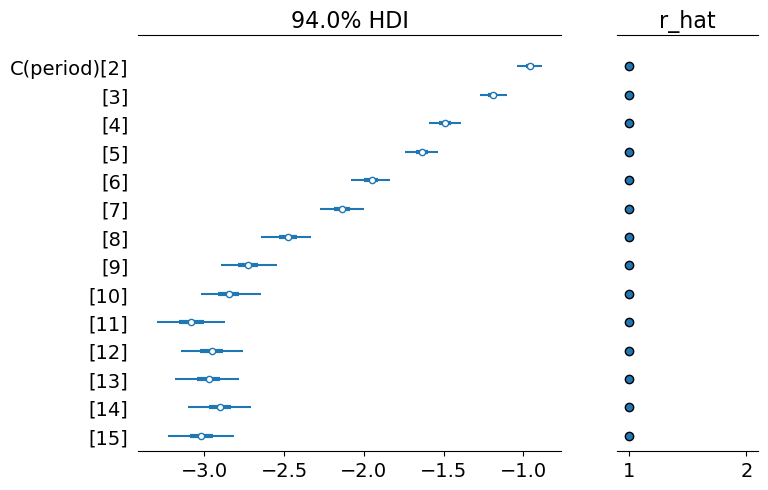

In [34]:
az.plot_forest(results_child, var_names=['C(period)'], combined=True, r_hat=True);

## The Key Quantity: Derived Survival Curves

One of the most powerful features of the regression approach is that we can derive full survival curves for any covariate pattern.

### How It Works: The Posterior Predictive Approach

The strategy is straightforward. We construct a "hypothetical subject" — a DataFrame with one row per time period, holding covariates fixed at the values we're interested in (e.g., male, official class, average birth decade). We then ask the fitted model: *for this subject, what would happen at each time period?*

Specifically, for each posterior draw we simulate whether the event occurs at each time point, given the model parameters from that draw. Averaging these 0/1 simulations across draws gives us the estimated hazard at each period. From the hazard sequence, survival and cumulative hazard follow mechanically:

$$\hat{h}(t) = \text{mean over draws of } \hat{Y}_t, \qquad \hat{S}(t) = \prod_{j=1}^{t}(1 - \hat{h}(j))$$

To obtain uncertainty bands, we use bootstrap resampling over the posterior draws: each resample produces a different hazard sequence and a different survival curve. The variation across resamples reflects how parameter uncertainty propagates through the cumulative product — giving us proper uncertainty bands on survival, not just pointwise uncertainty at each period.

::: {.callout-note}
## How This Differs from Standard Survival Curve Estimation

The classical **Kaplan-Meier estimator** computes survival non-parametrically from observed data — it counts events and at-risk subjects at each time point, without any regression model. It cannot condition on covariates (beyond stratification), and its uncertainty comes from counting noise.

The **Cox model** allows covariates, but survival curves are typically derived by plugging point estimates of $\hat{\beta}$ into the estimated baseline hazard. Confidence intervals, when computed, rely on the delta method or Greenwood's formula — asymptotic approximations that assume normality of the estimator.

Our Bayesian posterior predictive approach is different in two important ways:

1. **Full uncertainty propagation**: Each posterior draw uses a *different* set of parameters $(\beta, \alpha_t)$. The variation in the resulting survival curves directly reflects parameter uncertainty — no asymptotic approximations needed.
2. **Conditional prediction**: We can compute survival for *any* covariate profile, not just marginal or stratified summaries. Want the survival curve for a female child of a worker, born in the 1870s? Just set those covariate values and predict.

The price is computational: we need posterior samples, which requires MCMC. The payoff is that our uncertainty intervals are exact (up to Monte Carlo error) and naturally handle non-linearities, interactions, and complex model structures.
:::

Here's the function that implements this logic. It uses posterior predictive sampling (`kind='pps'`) to generate 0/1 event draws at each time period. Averaging these draws across posterior samples gives a hazard estimate per period. To obtain **uncertainty bands**, we bootstrap resample the posterior draws: each resample produces a different hazard sequence, from which we derive survival and cumulative hazard. The variation across resamples gives us 94% HDI bands on all three quantities.


In [35]:
def derive_survival_curves(model, results, pred_df, n_sims=200, model_type='cloglog'):
    """
    Derive hazard, cumulative hazard, and survival from a fitted Bambi model,
    with uncertainty bands via bootstrap resampling of posterior predictive draws.

    Parameters
    ----------
    model : bmb.Model
        Fitted Bambi model
    results : az.InferenceData
        MCMC results
    pred_df : DataFrame
        Prediction data with covariate values for each period
    n_sims : int
        Number of bootstrap resamples for uncertainty bands
    model_type : str, one of 'cloglog' or 'poisson'
        Controls how posterior predictive draws are processed.
        - 'cloglog': draws are already 0/1 (Bernoulli), used directly.
        - 'poisson': draws are non-negative integer counts. We clip at 1
          because counts > 1 are artefacts of the Poisson support — in
          the survival context each person-period is a binary event.
    """
    # Get posterior predictive samples
    predictions = model.predict(
        results,
        kind="pps",
        data=pred_df,
        sample_new_groups=True,
        inplace=False
    )

    # Extract draws: shape (chains, draws, n_periods)
    pps = predictions.posterior_predictive
    response_var = list(pps.data_vars)[0]
    draws = pps[response_var].values

    # For Poisson models, clip counts at 1 to recover binary interpretation
    if model_type == 'poisson':
        draws = np.clip(draws, 0, 1)

    # Reshape to (n_samples, n_periods)
    n_chains, n_draws_per_chain = draws.shape[0], draws.shape[1]
    draws_flat = draws.reshape(n_chains * n_draws_per_chain, -1)
    n_total = draws_flat.shape[0]

    # Point estimates: average across all draws
    hazards = draws_flat.mean(axis=0)
    cumulative_hazards = np.cumsum(hazards)
    survival_probs = np.cumprod(1 - hazards)

    # Bootstrap resampling for uncertainty bands
    rng = np.random.default_rng(42)
    hazard_sims = np.empty((n_sims, draws_flat.shape[1]))
    for i in range(n_sims):
        idx = rng.choice(n_total, size=n_total, replace=True)
        hazard_sims[i] = draws_flat[idx].mean(axis=0)

    survival_sims = np.cumprod(1 - hazard_sims, axis=1)
    cum_hazard_sims = np.cumsum(hazard_sims, axis=1)

    # HDI bands (94%)
    hazards_hdi = np.quantile(hazard_sims, [0.03, 0.97], axis=0)
    survival_hdi = np.quantile(survival_sims, [0.03, 0.97], axis=0)
    cum_hazards_hdi = np.quantile(cum_hazard_sims, [0.03, 0.97], axis=0)

    return {
        'hazards': hazards,
        'cum_hazards': cumulative_hazards,
        'survival': survival_probs,
        'hazards_hdi': hazards_hdi,
        'survival_hdi': survival_hdi,
        'cum_hazards_hdi': cum_hazards_hdi,
    }

The plotting function takes a list of scenario dicts (one per covariate profile) and displays hazard, cumulative hazard, and survival side by side. When HDI bands are available, it overlays them as shaded regions — making it easy to see where groups differ meaningfully versus where their uncertainty overlaps.


In [36]:
def plot_survival_curves(scenarios, title="Survival Analysis", show_hdi=True):
    """
    Plot hazard, cumulative hazard, and survival side-by-side,
    with optional HDI bands.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    colors = plt.cm.Set2(np.linspace(0, 1, max(len(scenarios), 2)))

    for i, scenario in enumerate(scenarios):
        periods = np.arange(1, len(scenario['hazards']) + 1)

        # Hazard
        axes[0].step(periods, scenario['hazards'], where='mid',
                     label=scenario['label'], color=colors[i], linewidth=2)
        if show_hdi and 'hazards_hdi' in scenario:
            axes[0].fill_between(periods, scenario['hazards_hdi'][0],
                                 scenario['hazards_hdi'][1],
                                 color=colors[i], alpha=0.15, step='mid')

        # Cumulative hazard
        axes[1].step(periods, scenario['cum_hazards'], where='mid',
                     label=scenario['label'], color=colors[i], linewidth=2)
        if show_hdi and 'cum_hazards_hdi' in scenario:
            axes[1].fill_between(periods, scenario['cum_hazards_hdi'][0],
                                 scenario['cum_hazards_hdi'][1],
                                 color=colors[i], alpha=0.15, step='mid')

        # Survival (prepend 1.0 at time 0)
        surv_plot = np.insert(scenario['survival'], 0, 1.0)
        time_plot = np.insert(periods, 0, 0)
        axes[2].step(time_plot, surv_plot, where='post',
                     label=scenario['label'], color=colors[i], linewidth=2)
        if show_hdi and 'survival_hdi' in scenario:
            surv_lo = np.insert(scenario['survival_hdi'][0], 0, 1.0)
            surv_hi = np.insert(scenario['survival_hdi'][1], 0, 1.0)
            axes[2].fill_between(time_plot, surv_lo, surv_hi,
                                 color=colors[i], alpha=0.15, step='post')

    axes[0].set_title('Hazard $h(t)$', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('P(Event in Period | Survived)')

    axes[1].set_title('Cumulative Hazard $H(t)$', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Accumulated Risk')

    axes[2].set_title('Survival $S(t)$', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('P(Survival Past Time $t$)')
    axes[2].set_ylim(0, 1.05)

    for ax in axes:
        ax.set_xlabel('Age (Years)')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

### Survival Curves by Social Class

Now let's use these functions to visualize how survival differed across social classes. We create prediction DataFrames for different covariate profiles, holding sex and birth decade at their baseline values, and vary only social class:


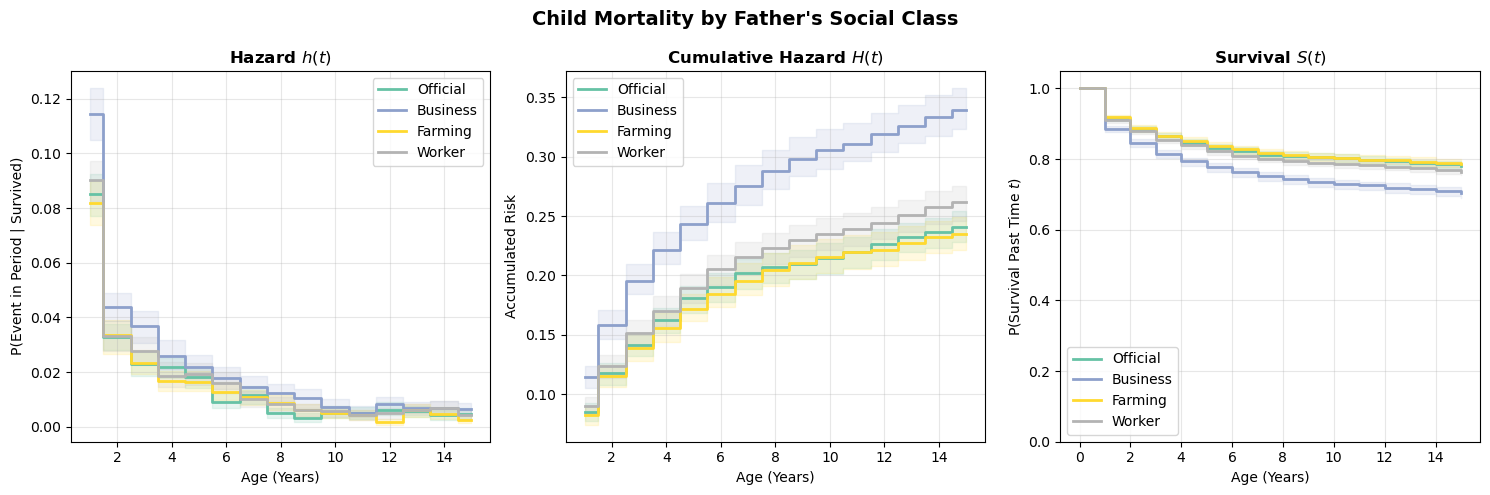

In [37]:
#| eval: true
#| fig-cap: "Estimated survival curves by father's social class, for males born in the reference decade"
# Define periods matching the child data
t_range = np.arange(1, 16)

# Create prediction scenarios for different social classes
def make_pred_df(socBranch, sex='male', periods=t_range):
    return pd.DataFrame({
        'period': periods,
        'sex': [sex] * len(periods),
        'socBranch': [socBranch] * len(periods),
        'birthdate_std': [0.0] * len(periods),
        'at_risk': [1] * len(periods) #  gives you the per-person rate, which is needed for hazard probability
    })

scenarios = []
for soc_class in ['official', 'business', 'farming', 'worker']:
    pred_df = make_pred_df(soc_class)
    curves = derive_survival_curves(model_child, results_child, pred_df)
    curves['label'] = soc_class.capitalize()
    scenarios.append(curves)

plot_survival_curves(scenarios, title="Child Mortality by Father's Social Class")

The survival curves reveal meaningful differences in childhood mortality across social strata. The hazard plot (left) shows the period-specific risk, the cumulative hazard (center) shows how risk accumulates, and the survival curve (right) shows the probability of surviving past each age. These three views are all derived from the same fitted model — they're just different ways of reading the same information.

### Survival Curves by Sex


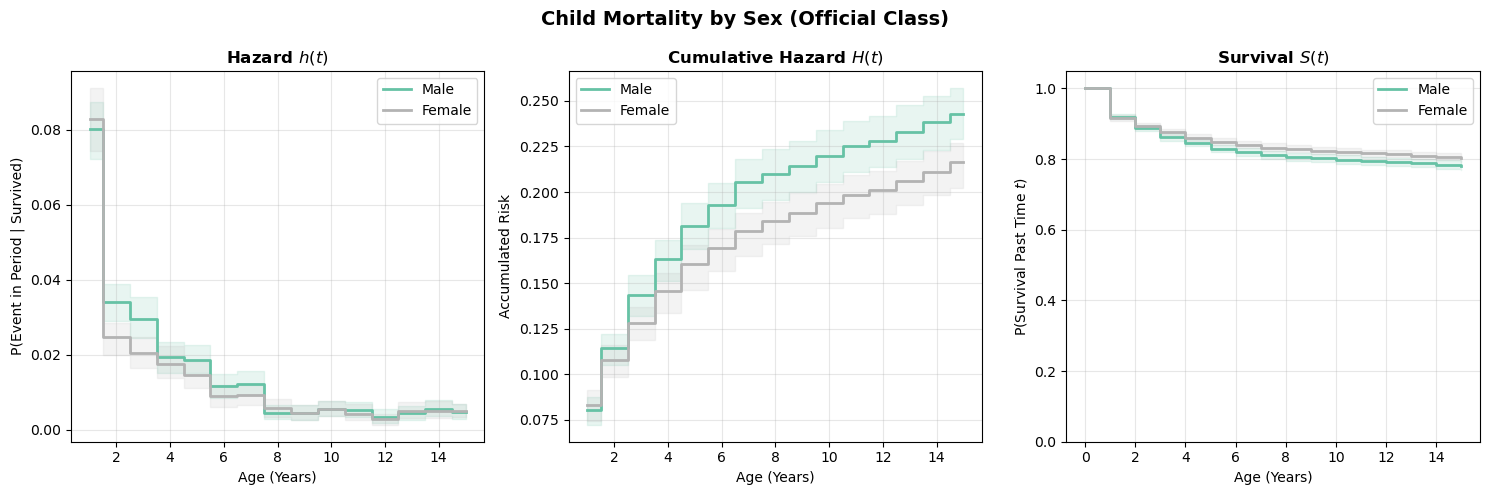

In [38]:
#| eval: true
#| fig-cap: "Estimated survival curves by sex"
scenarios_sex = []
for sex in ['male', 'female']:
    pred_df = make_pred_df('official', sex=sex)
    curves = derive_survival_curves(model_child, results_child, pred_df)
    curves['label'] = sex.capitalize()
    scenarios_sex.append(curves)

plot_survival_curves(scenarios_sex, title="Child Mortality by Sex (Official Class)")

## Modeling Choices: Baseline Hazard Specification

### Categorical Time Dummies

So far, we've used **categorical indicators** for each time period. This approach:

- ✅ Makes no assumptions about the shape of baseline hazard
- ✅ Is fully flexible (saturated)
- ❌ Cannot extrapolate beyond observed time periods
- ❌ Estimates many parameters (one per period minus reference)

### Spline Functions

An alternative is to model the baseline hazard as a **smooth function** using splines. We use it here to define a flexible view of the baseline hazard. But it can be used more generally to allow for time-varying covariates. This comes from the person-period formulation of the survival of the survival data. We only need to model the effects of such time-varying covariates as a spline. 


In [39]:

# Model with spline baseline hazard
model_spline = bmb.Model(
    'p(events, at_risk) ~ C(sex) + C(socBranch) + bs(period, df=4) + birthdate_std',
    data=df_binomial,
    family='binomial',
    link='cloglog'
)

results_spline = model_spline.fit(
    draws=1000,
    tune=2000,
    chains=4,
    target_accept=0.95,
    inference_method='numpyro',  # Use NUTS sampler
    random_seed=2535,
    idata_kwargs={"log_likelihood": True}
)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Spline approaches:

- ✅ Fewer parameters (degrees of freedom, not number of periods)
- ✅ Can extrapolate (with caution)
- ✅ Smooth, interpretable baseline hazard curves
- ❌ Impose smoothness assumptions that may not hold


In [27]:
az.summary(results_spline, var_names=['bs(period, df=4)'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"bs(period, df=4)[0]",-1.867,0.076,-2.016,-1.729,0.001,0.001,2679.0,2551.0,1.0
"bs(period, df=4)[1]",-1.781,0.130,-2.027,-1.537,0.003,0.002,2457.0,2695.0,1.0
"bs(period, df=4)[2]",-3.618,0.134,-3.857,-3.355,0.003,0.002,2586.0,2992.0,1.0
"bs(period, df=4)[3]",-2.784,0.093,-2.952,-2.603,0.002,0.002,3520.0,2359.0,1.0


::: {.callout-tip}
## Choosing Degrees of Freedom

For spline baseline hazards, start with 3-5 degrees of freedom. Use model comparison (LOO, WAIC) to assess fit. If the survival curves look unreasonably wiggly or smooth, adjust accordingly.
:::

### Survival Curves from the Spline Model

We can derive survival curves from the spline model using exactly the same `derive_survival_curves` function. The function doesn't care how the baseline hazard was specified — it just asks the model for predictions at each time point. This is one of the advantages of the posterior predictive approach: the same code works regardless of model internals.


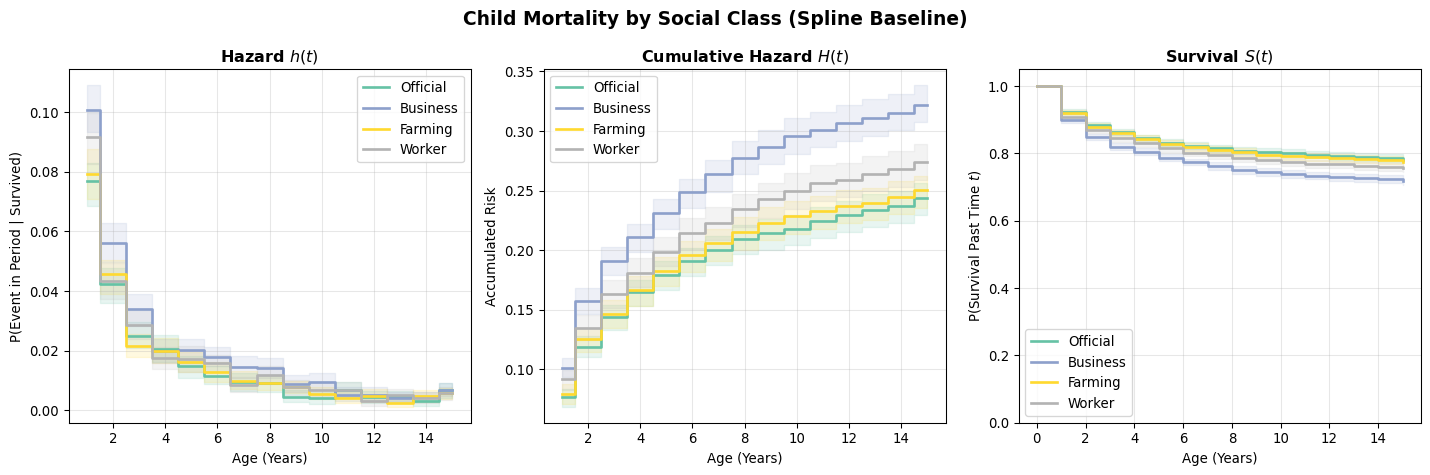

In [28]:
#| eval: true
#| fig-cap: "Survival curves from the spline baseline model, compared across social classes"
scenarios_spline = []
for soc_class in ['official', 'business', 'farming', 'worker']:
    pred_df = make_pred_df(soc_class)
    curves = derive_survival_curves(model_spline, results_spline, pred_df)
    curves['label'] = soc_class.capitalize()
    scenarios_spline.append(curves)

plot_survival_curves(scenarios_spline, title="Child Mortality by Social Class (Spline Baseline)")

Compare these curves to the categorical-dummies version above. The spline model imposes smoothness on the baseline hazard, which can be a virtue (fewer parameters, less overfitting to noisy period-specific estimates) or a liability (if the true hazard profile has sharp features the spline can't capture). In practice, the two approaches should broadly agree if the data is informative enough.

## Alternative Formulations: Poisson Regression

Another approach to discrete-time survival is **Poisson regression** with an exposure offset. This exploits the connection between Poisson processes and survival.

### The Poisson-Survival Connection

In continuous time, if events follow a Poisson process with rate $\lambda(t)$, then the time to first event follows an exponential distribution (or more generally, the survival function is $S(t) = e^{-\Lambda(t)}$).

In discrete time with aggregated data:

$$\text{Events}_{\text{stratum}} \sim \text{Poisson}(\text{Rate} \times \text{Person-Time})$$

The Poisson model uses a log link, so the linear predictor models $\log(\text{Expected Events})$. Since $\text{Expected Events} = \text{Rate} \times \text{Person-Time}$, taking logs gives:

$$\log(\text{Expected Events}) = \log(\text{Rate}) + \log(\text{Person-Time})$$

The covariates model $\log(\text{Rate})$ — but $\log(\text{Person-Time})$ isn't a parameter to estimate; it's a known quantity that varies across strata. The `offset()` term in the formula handles this: it adds `np.log(at_risk)` to the linear predictor with a coefficient fixed at 1, effectively dividing out the exposure. Without the offset, the model would treat a stratum with 100 person-years and 5 events the same as one with 10 person-years and 5 events — ignoring the fact that the second has a much higher rate.


In [40]:
# Poisson model with offset for person-time at risk
model_poisson = bmb.Model(
    'events ~ C(sex) + C(socBranch) + C(period) + birthdate_std + offset(np.log(at_risk))',
    data=df_binomial,
    family='poisson'
)

results_poisson = model_poisson.fit(
    draws=1000,
    tune=2000,
    chains=4,
    target_accept=0.95,
    random_seed=42,
    idata_kwargs={"log_likelihood": True},
    inference_method='numpyro'
)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

## Comparing Approaches

Both cloglog and Poisson models estimate **hazard rates**, but they parameterize the problem differently. The table below summarizes the key distinctions:

| Feature | Cloglog (Binomial) | Poisson |
|---------|-------------------|---------|
| **Interpretation** | Probability scale | Rate scale |
| **At-risk handling** | Binomial trials | Offset |
| **Large hazards** | Bounded (0,1) | Unbounded |
| **Cox equivalence** | Exact | Approximate |

A few points of elaboration:

- **Interpretation**: The cloglog model directly estimates hazard *probabilities* — bounded between 0 and 1. The Poisson model estimates an event *rate*, which is an expected count per unit of exposure. Rates can exceed 1 (e.g., 1.5 events per person-year), even though the per-period probability cannot.
- **At-risk handling**: In the cloglog model, the number of subjects at risk enters naturally through the binomial likelihood (events out of $n$ trials). In the Poisson model, exposure enters through the `offset()` term — a known quantity added to the linear predictor rather than a parameter to be estimated.
- **Large hazards**: Because the cloglog link maps to a probability, it automatically respects the (0, 1) bound. The Poisson rate is unbounded, so when hazards are large the two approaches can diverge — the Poisson may predict rates implying probabilities greater than 1, which is incoherent for survival.
- **Cox equivalence**: The cloglog model yields coefficients that are *exactly* log hazard ratios, identical to Cox proportional hazards. The Poisson model's log-rate coefficients approximate log hazard ratios, with the approximation improving as hazards get smaller.

For most practical purposes with moderate hazards (say $h(t) < 0.1$), results are very similar. The choice often comes down to data format: if you have individual-level person-period data, cloglog is natural; if you have aggregated event counts and person-time by stratum, Poisson is more convenient.


In [ ]:
# Compare using LOO
comparison = az.compare(
    {'Cloglog': results_child, 'Poisson': results_poisson},
    ic='loo'
)
print(comparison)

         rank     elpd_loo      p_loo  elpd_diff        weight         se  \
Poisson     0 -1285.851012  35.797955   0.000000  1.000000e+00  47.261980   
Cloglog     1 -1292.844083  36.794059   6.993071  7.271961e-15  48.379566   

              dse  warning scale  
Poisson  0.000000    False   log  
Cloglog  2.000361     True   log  


The LOO comparison confirms what we'd expect: the two models are **functionally equivalent** for this dataset. Any difference in predictive accuracy is negligible — well within the standard error of the LOO estimate. This is the typical outcome when hazards are moderate. The cloglog and Poisson formulations are two different parameterizations of the same underlying survival process, so they should (and do) agree.

### Survival Curves from the Poisson Model

Deriving survival curves from a Poisson model requires an extra step compared to the binomial cloglog model. The Poisson model estimates a **rate** (expected count per unit of exposure), not a probability. To get hazard probabilities, we need to convert:

$$\hat{\lambda}(t) = \exp(\hat{\eta}_t), \qquad \hat{h}(t) = 1 - \exp(-\hat{\lambda}(t))$$

The second expression is the complement of the Poisson "zero-event" probability — the probability that at least one event occurs during the interval, given a rate $\lambda$. When rates are small, $h(t) \approx \lambda(t)$, which is why Poisson and cloglog results agree closely in low-hazard settings.

There is a subtlety when using posterior predictive draws from the Poisson model. With `at_risk=1`, each draw simulates an event count from a Poisson distribution — typically 0 or 1, but occasionally 2 or more. Those counts above 1 are artefacts of the Poisson support, not real multiple events: in the survival context, a person either experiences the event in a period or they don't. We clip these draws at 1 before averaging, which recovers the binary interpretation and makes the Poisson draws directly comparable to the 0/1 draws from the binomial model.


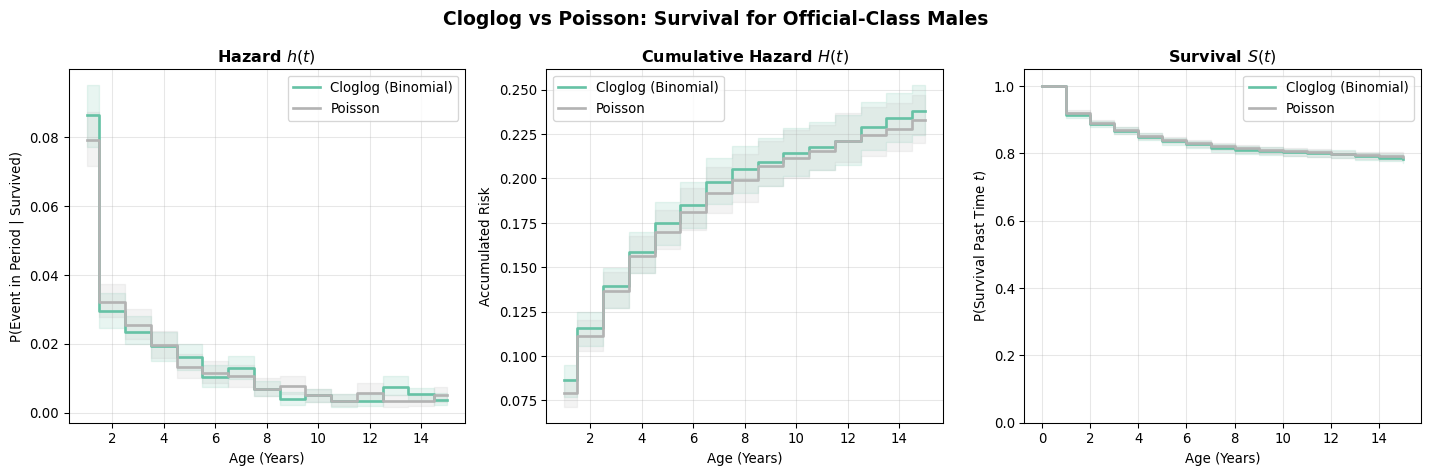

In [ ]:

#| fig-cap: "Survival curves derived from the Poisson rate model, compared to the binomial cloglog model"
# Compare Poisson and cloglog survival curves for the baseline profile
pred_baseline = make_pred_df('official', sex='male')

curves_clog = derive_survival_curves(model_child, results_child, pred_baseline)
curves_clog['label'] = 'Cloglog (Binomial)'

curves_pois = derive_survival_curves(model_poisson, results_poisson, pred_baseline, model_type='poisson')
curves_pois['label'] = 'Poisson'

plot_survival_curves([curves_clog, curves_pois],
    title="Cloglog vs Poisson: Survival for Official-Class Males")

The two formulations produce nearly identical survival curves — reassuring, since they're modeling the same underlying process. The small differences arise because the Poisson model doesn't bound hazard probabilities at 1 (the rate can exceed 1 in principle, though it rarely does with moderate hazards). In practice, either formulation works well; the choice is mainly about modelling convenience and whether you prefer to think in terms of probabilities (binomial) or rates (Poisson).

## From Grains of Sand to Full Survival Curves
 
We began with the Sorites paradox: when does a collection of grains become a heap? The question seemed philosophical, but it captures something fundamental about survival processes. Risk accumulates grain by grain, period by period, until a threshold is crossed and a state-transition occurs. No single moment is decisive, yet together they determine fate.
 
The regression framework we've developed makes this accumulation process explicit and tractable. By restructuring survival data into person-period format, we transformed the question "when will the event occur?" into a sequence of simpler questions: "did it occur *this* period, given it hasn't occurred yet?" Each row in our expanded dataset represents one grain of sand, one increment of risk. The hazard function $h(t)$ governs how much risk each period contributes. The survival function $S(t) = \prod(1-h(j))$ tracks the cumulative improbability of having avoided the threshold.

### What We've Gained
 
This generality brings real advantages. We've seen how:
 
- **Flexibility in baseline hazards**: Categorical time dummies impose no assumptions about the shape of risk over time—fully saturated, fully flexible. Splines offer parsimony when we believe the underlying process is smooth. The choice is ours, not dictated by specialized software.
 
- **Interpretable covariate effects**: The coefficient on `treatment` isn't an abstract parameter—it's a log hazard ratio. $\exp(\beta) = 1.65$ means treated subjects accumulate risk 65% faster each period. This multiplicative interpretation applies to any covariate: social class, sex, birth cohort. The regression framework makes these effects explicit.
 
- **Full uncertainty propagation**: Our Bayesian posterior predictive approach doesn't just give point estimates—it traces how parameter uncertainty flows through the entire survival curve. Each posterior draw uses different $(\beta, \alpha_t)$ values, producing a different hazard sequence, a different cumulative product, a different survival trajectory. The variation across draws is our uncertainty, represented exactly (up to Monte Carlo error), without asymptotic approximations.
 
- **Conditional prediction for any profile**: Want survival curves for a female child of a worker, born in the 1870s? Just set those covariates and predict. The model doesn't stratify or marginalize—it conditions directly on the covariate values you care about.
 
### The Discrete-Time Approximation
 
But we should be honest about what we've simplified. Real survival processes—disease progression, mechanical failure, time to employment—don't tick forward in discrete intervals. They evolve continuously. When we bin time into years or months or visits, we're imposing structure on an inherently continuous process.
 
This discretization is pragmatic: data often arrives in discrete chunks (annual checkups, monthly job reports), and the person-period framework handles censoring naturally. For many applications, discrete time is perfectly adequate. If hazards are roughly constant within intervals, and events are rare enough that multiple events per interval are implausible, the discrete approximation introduces negligible error.
 
But the approximation has limits:
 
- **Interval choice matters**: Coarse binning (e.g., yearly intervals when events cluster in specific months) can miss important dynamics. Too-fine binning creates sparse data and computational burden.
 
- **Ties are artifacts**: In continuous time, exact ties (two subjects experiencing the event at precisely the same moment) have probability zero. In discrete time, all events within an interval are "tied." The cloglog link handles this gracefully via the proportional hazards structure, but we're still imposing discreteness where none exists.
 
- **Time-varying covariates require care**: If a covariate changes mid-interval (say, a patient starts treatment partway through month 3), the discrete model must either ignore intra-interval changes or subdivide intervals further—adding complexity. 

Despite these limitations, discrete-time models are often the *right* choice. Time-varying covariates can be specified in a straightforward way, baseline hazards can be estimated freely taking any shape required. Our concerns often map to temporal processes divided into calendar time and then discrete choice models answer the right question. 

### What Comes Next: Continuous Time
 
These limitations point toward the natural next step: **continuous-time survival models**. In the companion notebook, we'll relax the discrete-time assumption and work directly with the continuous hazard function $\lambda(t)$—the instantaneous rate of risk accumulation.Continuous formulations bring new modeling choices:

- **Parametric baselines**: Weibull, Gompertz, log-logistic distributions each encode different assumptions about how hazards evolve—monotonically increasing (aging), bathtub-shaped (early failures then wear-out), or peaked (temporary elevated risk).
 
- **Exact handling of censoring**: Continuous models separate the event time distribution from the observation process cleanly—no need to bin into intervals and worry about partial exposure.

- **Parametric Simplicity improves computational burdens** often in the continuous time case we can avoid the person-period formulation of the data.
 
The conceptual framework remains the same: we're still modeling hazard functions, still deriving survival curves via $S(t) = \exp(-\int_0^t \lambda(u) du)$, still using regression to map covariates to risk. But we'll work in the limit where time intervals shrink to zero—the continuous process underlying the discrete approximation we've explored here. 

In [32]:
import sys
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Bambi version: {bmb.__version__}")
print(f"ArviZ version: {az.__version__}")

Python version: 3.13.11 | packaged by conda-forge | (main, Dec  6 2025, 11:28:54) [Clang 19.1.7 ]
NumPy version: 2.3.5
Pandas version: 2.3.3
Bambi version: 0.16.0
ArviZ version: 0.23.0


## Author

This notebook was contributed by Nathaniel Forde: https://nathanielf.github.io/